**Importing all Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint
import random
from sklearn.metrics import accuracy_score

from deap import base, creator, tools, algorithms
# prep
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier



In [2]:
data = pd.read_csv("survey.csv")  

**Data Preprocessing**

In [3]:
data.head(5)   #showing top 5 rows of data

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
#dealing with missing data
train_df=data
train_df.drop(['comments'], axis= 1, inplace=True)
train_df.drop(['state'], axis= 1, inplace=True)
train_df.drop(['Timestamp'], axis= 1, inplace=True)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [5]:
train_df = data[['Age',
    'Gender',
    'self_employed',
    'family_history',
    'treatment',
    'work_interfere',
    'no_employees',
    'remote_work',
    'tech_company',
    'benefits',
    'care_options',
    'wellness_program',
    'seek_help',
    'anonymity',
    'leave',
    'mental_health_consequence',
    'phys_health_consequence',
    'coworkers',
    'supervisor',
    'mental_health_interview',
    'phys_health_interview',
    'mental_vs_physical',
    'obs_consequence'
]]
train_df.shape

(1259, 23)

In [6]:
train_df.isnull().sum()    #calculating sum of null values

Age                            0
Gender                         0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [7]:
#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

C:\Users\rajjn\AppData\Local\Temp\ipykernel_644\479432589.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
C:\Users\rajjn\AppData\Local\Temp\ipykernel_644\479432589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)
C:\Users\rajjn\AppData\Local\Temp\ipykernel_644\479432589.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

['female' 'male' 'trans']


In [8]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,NaN,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,male,NaN,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,male,NaN,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,male,NaN,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,male,NaN,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


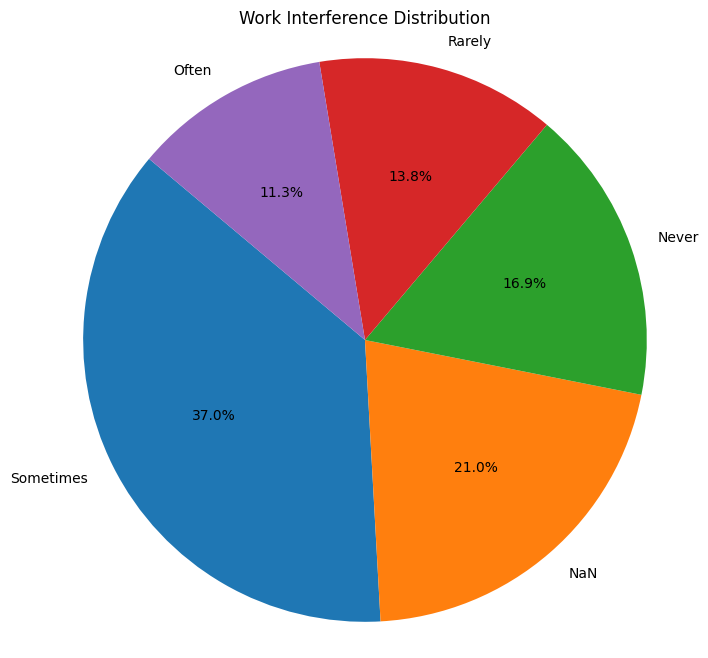

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_df' is your DataFrame
# Replace NaN values in 'work_interfere' column with "Don't know"
train_df['work_interfere'] = train_df['work_interfere'].fillna("Don't know")

# Calculate counts for each category
counts = train_df['work_interfere'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Work Interference Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [10]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString
train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


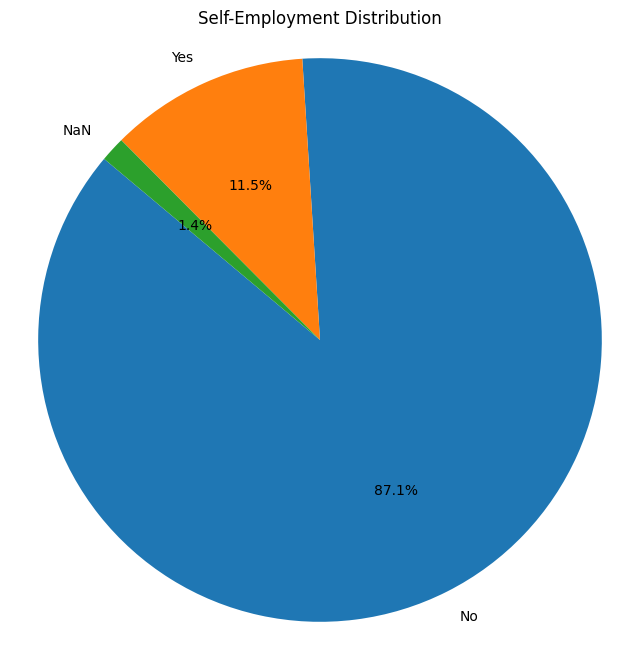

In [11]:
import matplotlib.pyplot as plt

# Assuming 'train_df' is your DataFrame

# Calculate counts for each category
counts = train_df['self_employed'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Self-Employment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [12]:
#There are only 1.4% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString

train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())
train=train_df

['No' 'Yes']


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1257 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1257 non-null   int64 
 1   Gender                     1257 non-null   object
 2   self_employed              1257 non-null   object
 3   family_history             1257 non-null   object
 4   treatment                  1257 non-null   object
 5   work_interfere             1257 non-null   object
 6   no_employees               1257 non-null   object
 7   remote_work                1257 non-null   object
 8   tech_company               1257 non-null   object
 9   benefits                   1257 non-null   object
 10  care_options               1257 non-null   object
 11  wellness_program           1257 non-null   object
 12  seek_help                  1257 non-null   object
 13  anonymity                  1257 non-null   object
 14  leave        

In [14]:
#complete missing age with mean
train['Age'].fillna(train['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train['Age'])
s[s<18] = train['Age'].median()
train['Age'] = s
s = pd.Series(train['Age'])
s[s>120] = train['Age'].median()
train['Age'] = s
#Ranges of Age
train['age_range'] = pd.cut(train['Age'], [0,20,25,30,65,100], labels=["0-20", "21-25","26-30", "31-65", "66-100"], include_lowest=True)

C:\Users\rajjn\AppData\Local\Temp\ipykernel_644\2339553739.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["Age"], bins=24)
c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

Text(0.5, 0, 'Age')

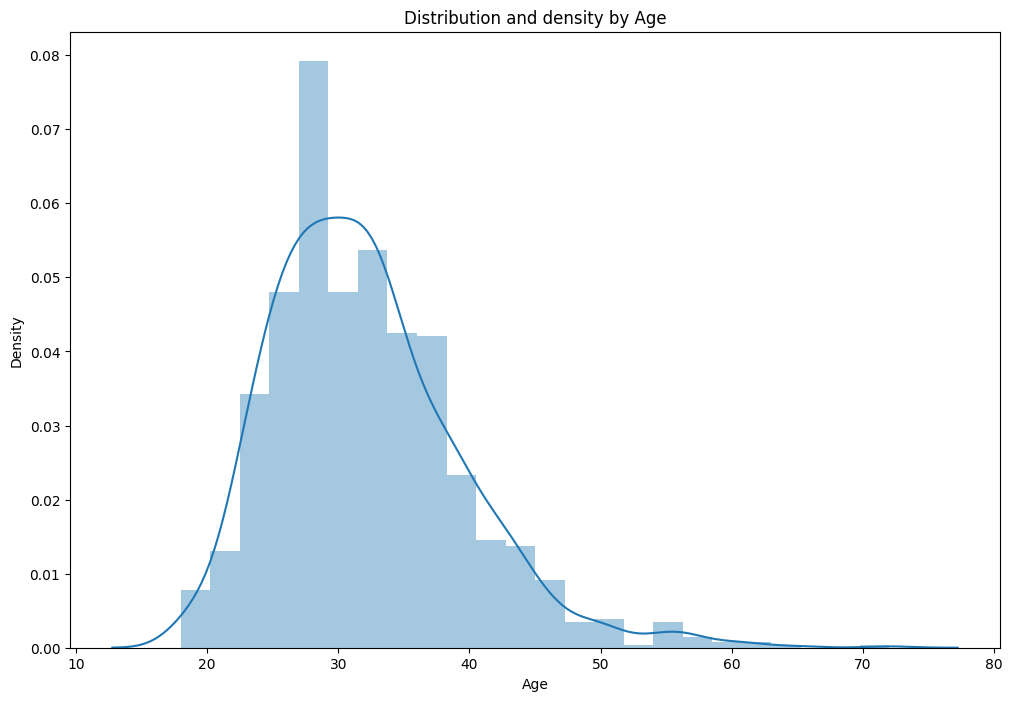

In [15]:
# Distribution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train["Age"], bins=24)
plt.title("Distribution and density by Age")
plt.xlabel("Age")

c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

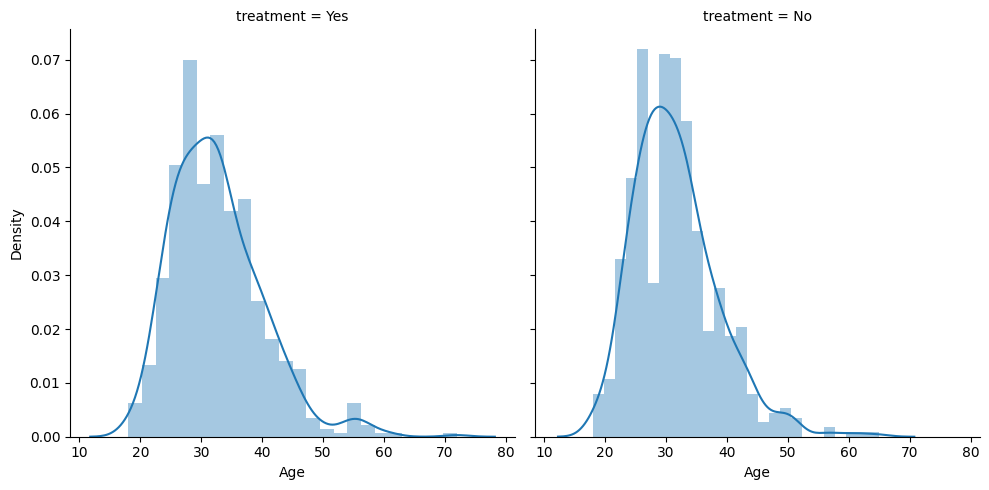

In [16]:
g = sns.FacetGrid(train_df, col='treatment', height=5)
g = g.map(sns.distplot, "Age") 

In [17]:
le = LabelEncoder()      # this is used to convert string values to numerical values

# Columns to encode
columns_to_encode = ['Age',
    'Gender',
    'self_employed',
    'family_history',
    'treatment',
    'work_interfere',
    'no_employees',
    'remote_work',
    'tech_company',
    'benefits',
    'care_options',
    'wellness_program',
    'seek_help',
    'anonymity',
    'leave',
    'mental_health_consequence',
    'phys_health_consequence',
    'coworkers',
    'supervisor',
    'mental_health_interview',
    'phys_health_interview',
    'mental_vs_physical',
    'obs_consequence']

# Apply LabelEncoder on each of the categorical columns
for column in columns_to_encode:
    train_df[column] = le.fit_transform(train_df[column])      #converting all columns to numerical values

In [18]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

Age [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Gender [0, 1, 2]
self_employed [0, 1]
family_history [0, 1]
treatment [0, 1]
work_interfere [0, 1, 2, 3, 4]
no_employees [0, 1, 2, 3, 4, 5]
remote_work [0, 1]
tech_company [0, 1]
benefits [0, 1, 2]
care_options [0, 1, 2]
wellness_program [0, 1, 2]
seek_help [0, 1, 2]
anonymity [0, 1, 2]
leave [0, 1, 2, 3, 4]
mental_health_consequence [0, 1, 2]
phys_health_consequence [0, 1, 2]
coworkers [0, 1, 2]
supervisor [0, 1, 2]
mental_health_interview [0, 1, 2]
phys_health_interview [0, 1, 2]
mental_vs_physical [0, 1, 2]
obs_consequence [0, 1]
age_range ['0-20', '21-25', '26-30', '31-65', '66-100']


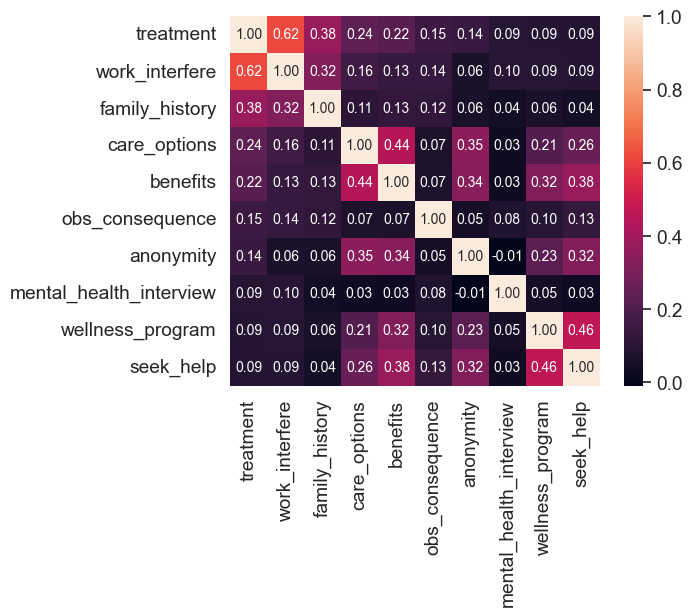

In [19]:
corrmat = train_df.corr()
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Splitting the Data into Test and Train**

In [20]:
# Split the dataset into training and test sets
target = train_df['mental_health_consequence']
train_df = train_df.drop('mental_health_consequence', axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=42)

In [21]:
from sklearn import metrics

# Create a decision tree classifier
clf = RandomForestClassifier()
# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
clf.classes_

Accuracy: 0.6944444444444444


array([0, 1, 2], dtype=int64)

In [22]:
from sklearn import metrics

# Create a decision tree classifier
clf = DecisionTreeClassifier()
# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5277777777777778


In [23]:
from sklearn.linear_model import LogisticRegression

# Create a decision tree classifier
clf = LogisticRegression()
# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.626984126984127


c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn.neighbors import KNeighborsClassifier
# Create a k-nearest neighbors classifier with k=3 (you can adjust the value of k)
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4642857142857143


In [25]:
from sklearn.svm import SVC

# Create an SVM model
svm_model = SVC()

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")

SVM Accuracy: 0.5396825396825397


In [26]:
from sklearn.neural_network import MLPClassifier

# Create an MLP (Multi-Layer Perceptron) model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = mlp_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy: {accuracy}")

Neural Network Accuracy: 0.6031746031746031


c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


**Ganeting Algorithm**

In [27]:
# Define the fitness function
def get_accuracy(individual):
    # Convert the binary individual to indices for feature selection
    indices = [index for index, value in enumerate(individual) if value == 1]
    # Select those features
    X_train_selected = X_train.iloc[:, indices]
    X_test_selected = X_test.iloc[:, indices]

    # Create and train the classifier
    classifier = RandomForestClassifier()
    classifier.fit(X_train_selected, y_train)

    # Predict and get the accuracy for the selected features
    predictions = classifier.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)

    return (accuracy,)

# Define the genetic algorithm components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X_train.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", get_accuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population
population = toolbox.population(n=50)

# Run the genetic algorithm
NGEN = 1
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Get the best individual
best_ind = tools.selBest(population, 1)[0]
best_features = [index for index, value in enumerate(best_ind) if value == 1]
print("Best individual is: %s\nwith accuracy: %s" % (best_ind, best_ind.fitness.values))

Best individual is: [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
with accuracy: (0.6706349206349206,)


In [28]:
new_train_df=train_df.iloc[:, best_features]

In [29]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1257 entries, 0 to 1258
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      1257 non-null   int64
 1   self_employed            1257 non-null   int64
 2   family_history           1257 non-null   int64
 3   work_interfere           1257 non-null   int64
 4   no_employees             1257 non-null   int64
 5   remote_work              1257 non-null   int64
 6   care_options             1257 non-null   int64
 7   wellness_program         1257 non-null   int64
 8   seek_help                1257 non-null   int64
 9   anonymity                1257 non-null   int64
 10  leave                    1257 non-null   int64
 11  phys_health_consequence  1257 non-null   int64
 12  supervisor               1257 non-null   int64
 13  mental_health_interview  1257 non-null   int64
 14  phys_health_interview    1257 non-null   int64
 15  obs_conse

**Training the Machine Learning Model on Best Features(Which we extracted from GA)**

In [30]:
# Use the selected features to train the final model
final_classifier = RandomForestClassifier()
final_classifier.fit(X_train.iloc[:, best_features], y_train)

RandomForestClassifier()

**Testing and Validation of the Model**

In [31]:
# Evaluate the final model
final_predictions = final_classifier.predict(X_test.iloc[:, best_features])
final_accuracy = accuracy_score(y_test, final_predictions)
print("Final accuracy: %s" % final_accuracy)

Final accuracy: 0.6507936507936508


In [32]:
def get_yes_no_input(question):
    while True:
        response = input(question + " (yes/no): ").strip().lower()
        if response in ['yes', 'no']:
            return response
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")

def get_numeric_input(question):
    while True:
        response = input(question + ": ").strip()
        if response.isdigit():
            return int(response)
        else:
            print("Invalid input. Please enter a number.")

def get_input(question, options=None):
    while True:
        response = input(question + ": ").strip()
        if options and response.lower() not in [option.lower() for option in options]:
            print(f"Invalid input. Please enter one of the following: {', '.join(options)}")
        elif not response:
            print("This field cannot be empty. Please provide a response.")
        else:
            return response

# obs_consequence = get_yes_no_input("Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?")

    # Specific questions
    # age = ("Age")
    
    # gender = get_input("Gender", options=["Male", "Female", "Other"])
    
    # self_employed = get_yes_no_input("Are you self employed?")
    
    # family_history = get_yes_no_input("Do you have a family history of mental illness?")
    
    # work_interfere = get_input("If you have a mental health condition, do you feel that it interferes with your work?", options=["Never", "Rarely", "Sometimes", "Often", "Always"])
    # no_employees = get_input("How many employees does your company or organisation have?", options=["1-5", "6-25", "26-100", "101-500", "501-1000", "More than 1000"])
    # remote_work = get_yes_no_input("Do you work remotely?")
    # tech_company = get_yes_no_input("Is your employer primarily a tech company organisation?")
    # benefits = get_yes_no_input("Does your employer provide mental health benefits?")
    # care_options = get_yes_no_input("Do you know the options for mental health care your employer provides?")
    # wellness_program = get_yes_no_input("Has your employer ever discussed mental health as part of an employee wellness program?")
    # seek_help = get_yes_no_input("Does your employer provide resources to learn more about mental health issues and how to seek help?")
    # anonymity = get_yes_no_input("Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?")
    # leave = get_input("How easy is it for you to take medical leave for a mental health condition?", options=["Very easy", "Somewhat easy", "Neither easy nor difficult", "Somewhat difficult", "Very difficult"])
    # mental_health_consequence = get_yes_no_input("Do you think that discussing a mental health issue with your employer would have negative consequences?")
    # phys_health_consequence = get_yes_no_input("Do you think that discussing a physical health issue with your employer would have negative consequences?")
    # coworkers = get_yes_no_input("Would you be willing to discuss a mental health issue with your coworkers?")
    # supervisor = get_yes_no_input("Would you be willing to discuss a mental health issue with your direct supervisors?")
    # mental_health_interview = get_yes_no_input("Would you bring up a mental health issue with a potential employer in an interview?")
    # phys_health_interview = get_yes_no_input("Would you bring up a physical health issue with a potential employer in an interview?")
    # mental_vs_physical = get_yes_no_input("Do you feel that your employer takes mental health as seriously as physical health?")
    # obs_consequence = get_yes_no_input("Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?")
# Initial responses
responses={}
age = 20
gender = "Male"
self_employed = "no"
family_history = "yes"
treatment = "yes"
work_interfere = "Always"
no_employees = "1-5"
remote_work = "no"
tech_company = "no"
benefits = "yes"
care_options = "yes"
wellness_program = "yes"
seek_help = "yes"
anonymity = "no"
leave = "Very easy"
mental_health_consequence = "no"
phys_health_consequence = "no"
coworkers = "no"
supervisor = "no"
mental_health_interview = "yes"
phys_health_interview = "yes"
mental_vs_physical = "no"
obs_consequence = "no"

# Gender mapping
gender_mapping = {"female": 0, "male": 1, "trans": 2}
gender = gender_mapping.get(gender.lower(), gender)

# Mapping for categorical values
work_interfere_mapping = {"Never": 0, "Rarely": 1, "Sometimes": 2, "Often": 3, "Always": 4}
no_employees_mapping = {"1-5": 0, "6-25": 1, "26-100": 2, "101-500": 3, "501-1000": 4, "More than 1000": 5}
leave_mapping = {"Very easy": 0, "Somewhat easy": 1, "Neither easy nor difficult": 2, "Somewhat difficult": 3, "Very difficult": 4}

# Update values with numerical mappings
responses["work_interfere"] = work_interfere_mapping.get(work_interfere.capitalize(), work_interfere)
responses["no_employees"] = no_employees_mapping.get(no_employees, no_employees)
responses["leave"] = leave_mapping.get(leave, leave)

# Convert "yes" to 1 and "no" to 0
responses = {
    "age": age,
    "gender": gender,
    "self_employed": 1 if self_employed == "yes" else 0,
    "family_history": 1 if family_history == "yes" else 0,
    "treatment": 1 if treatment == "yes" else 0,
    "work_interfere": responses["work_interfere"],
    "no_employees": responses["no_employees"],
    "remote_work": 1 if remote_work == "yes" else 0,
    "tech_company": 1 if tech_company == "yes" else 0,
    "benefits": 1 if benefits == "yes" else 0,
    "care_options": 1 if care_options == "yes" else 0,
    "wellness_program": 1 if wellness_program == "yes" else 0,
    "seek_help": 1 if seek_help == "yes" else 0,
    "anonymity": 1 if anonymity == "yes" else 0,
    "leave": responses["leave"],
    "mental_health_consequence": 1 if mental_health_consequence == "yes" else 0,
    "phys_health_consequence": 1 if phys_health_consequence == "yes" else 0,
    "coworkers": 1 if coworkers == "yes" else 0,
    "supervisor": 1 if supervisor == "yes" else 0,
    "mental_health_interview": 1 if mental_health_interview == "yes" else 0,
    "phys_health_interview": 1 if phys_health_interview == "yes" else 0,
    "mental_vs_physical": 1 if mental_vs_physical == "yes" else 0,
    "obs_consequence": 1 if obs_consequence == "yes" else 0
}

# Print the final responses
print(responses)



{'age': 20, 'gender': 1, 'self_employed': 0, 'family_history': 1, 'treatment': 1, 'work_interfere': 4, 'no_employees': 0, 'remote_work': 0, 'tech_company': 0, 'benefits': 1, 'care_options': 1, 'wellness_program': 1, 'seek_help': 1, 'anonymity': 0, 'leave': 0, 'mental_health_consequence': 0, 'phys_health_consequence': 0, 'coworkers': 0, 'supervisor': 0, 'mental_health_interview': 1, 'phys_health_interview': 1, 'mental_vs_physical': 0, 'obs_consequence': 0}


In [33]:
# Convert the responses dictionary into a DataFrame
response_df = pd.DataFrame([responses])
columns_to_encode = [
    'age', 'gender', 'self_employed', 'family_history','treatment', 'work_interfere',
       'no_employees', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
        'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'
]
for column in columns_to_encode:
    response_df[column] = response_df[column]
response_df.values

array([[20,  1,  0,  1,  1,  4,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,
         0,  0,  0,  1,  1,  0,  0]], dtype=int64)

In [34]:

# Ensure the DataFrame has the same feature ordering and selection as used by the final model
response_df_selected = response_df.iloc[:, best_features]
# print(response_df_selected)
# Convert the DataFrame to a format suitable for prediction
# Assuming that the model expects numerical input, you might need to encode categorical variables
# Here, we're assuming the data is already in the correct numerical format
# Apply LabelEncoder on each of the categorical columns
response_vector = response_df_selected.values
# Use the final model to predict
single_prediction = final_classifier.predict(response_vector)

print("Prediction for the single response vector:", single_prediction[0])


Prediction for the single response vector: 0


c:\Users\rajjn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [35]:
final_classifier.classes_

array([0, 1, 2], dtype=int64)

In [36]:
value = int(single_prediction)
print("Result:")
if value==0:
  print("This Patient Will not Have Mental Health Issues")
elif value==1:
  print("This Patient May  Have Mental Health Issues")
elif value==2:
  print("This Patient Will  Have Mental Health Issues")

Result:
This Patient Will not Have Mental Health Issues


C:\Users\rajjn\AppData\Local\Temp\ipykernel_644\4152387354.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(single_prediction)
